<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/TensorFlow_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
Neural style transfer is an optimization technique used to take three images, 
a content image, a style reference image (such as an artwork by a famous 
painter), and the input image you want to style -- and blend them together 
such that the input image is transformed to look like the content image, 
but “painted” in the style of the style image.

"""

'\nNeural style transfer is an optimization technique used to take three images, \na content image, a style reference image (such as an artwork by a famous \npainter), and the input image you want to style -- and blend them together \nsuch that the input image is transformed to look like the content image, \nbut “painted” in the style of the style image.\n\n'

In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [0]:
!ls /tmp/nst

1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Green_Sea_Turtle_grazing_seagrass.jpg
Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
The_Great_Wave_off_Kanagawa.jpg
Tuebingen_Neckarfront.jpg
Vassily_Kandinsky,_1913_-_Composition_7.jpg


In [0]:
"""
The principle of neural style transfer is to define two distance functions:
- L_{content}
- L_{style}


L_{content}: describes difference in the content of two images 
L_{style}:   describes difference between two images in terms of their style, . 

Then, given three images, a desired style image, a desired content image, and the input image (initialized with the content image), 
we try two things
1. We try to transform the input image to minimize the content distance with the content image  
2. We try to transform the input image to minimize the  style distance with the style image. 

Using back-propogation we create a new image that matches the content of the content image and the style of the style image.

"""

'\nThe principle of neural style transfer is to define two distance functions:\n- L_{content}\n- L_{style}\n\n\nL_{content}: describes difference in the content of two images \nL_{style}:   describes difference between two images in terms of their style, . \n\nThen, given three images, a desired style image, a desired content image, and the input image (initialized with the content image), \nwe try two things\n1. We try to transform the input image to minimize the content distance with the content image  \n2. We try to transform the input image to minimize the  style distance with the style image. \n\nUsing back-propogation we create a new image that matches the content of the content image and the style of the style image.\n\n'

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [0]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

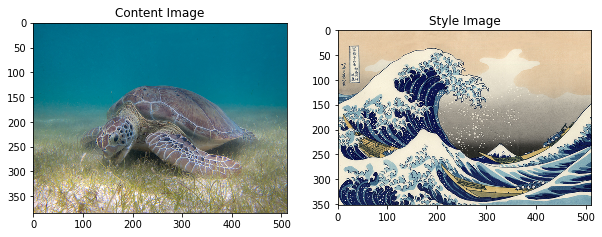

In [0]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()


Use of VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

tf.keras.applications.vgg19.preprocess_input

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
"""
Tutorial on np.squeeze
x = np.array([[[0], [1], [2]]])
print(x.shape)
#(1, 3, 1)
print(np.squeeze(x).shape)
#(3,)
print(np.squeeze(x, 0))
print(x)


[[[0]       np.squeeze(x, 0)    [[0]
  [1]       ===============>     [1]
  [2]]]                          [2]] 
  
"""

'\nTutorial on np.squeeze\nx = np.array([[[0], [1], [2]]])\nprint(x.shape)\n#(1, 3, 1)\nprint(np.squeeze(x).shape)\n#(3,)\nprint(np.squeeze(x, 0))\nprint(x)\n\n\n[[[0]       np.squeeze(x, 0)    [[0]\n  [1]       ===============>     [1]\n  [2]]]                          [2]] \n  \n'

In [0]:
"""
In order to view the outputs of our optimization, we are required to perform 
the inverse preprocessing step. Furthermore, since our optimized image may take 
its values anywhere between -infty and +infty, we must clip to maintain our 
values from within the 0-255 range.

"""
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

Extracting the content and style

In order to get both the content and style representations of our image, we will look at some intermediate layers within our model which uses VGG19, a pretrained image classification network

The Logic behind using intermediate layers of VGG19

in order for a VGG19 to perform image classification (which VGG19 has been trained to do), it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image.

In [0]:
# Content layer where will pull our feature maps

content_layers = ['block5_conv2']

style_layers = [
    
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
  """Creates our model with access to intermediate layers by accessing VGG19"""
  
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  # Get output layers corresponding to style and content layers 
  
  style_output = [ vgg.get_layer(name).output for name in style_layers]
  content_output = [ vgg.get_layer(name).output for name in content_layers]

  model_output = style_output + content_output
  #Build Our Model
  return models.Model(vgg.input, model_output)

Content Loss

The content loss is calculated using desired content image and our base input image. We  take the euclidean distance between the two intermediate representations of those images. These  intermediate representations of images are the outputs from our model. 

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

Style Loss

Similar to Content Loss however, instead of euclidean distance one uses compare the Gram matrices of the two outputs. We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix and the image.

We get two values of Gram matrix one the style image another the base image for each style intermediate layer (block1_conv1 ..., block5_conv1).

Take the difference of Gram matrices one for base another for style and aggreate to get total loss.


In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first
  channels = int(input_tensor.shape[-1])
  
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  
  gram = tf.matmul(a, a, transpose_a=True)
  return gram/tf.cast(n, tf.float32)

In [0]:
def get_style_loss(base_style, gram_target):
  # height, width, num filters of each layer
  height, width, channels = base_style.get_shape().as_list()
  
  gram_style = gram_matrix(base_style)
  
  loss = tf.reduce_mean(tf.square(gram_style - gram_target))
  return loss

In [0]:
"""Use Adam Optimizer

The key difference between Neural Style and Other Predictive algorithms is that here one modifies the input data itself to
mimimize the loss
"""

def get_feature_representation(model, content_path, style_path):
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  content_output = model(content_image)
  style_output = model(style_image)
  
  # Get the style and content feature representations from our model  
  content_features = [ content_layer[0] for content_layer in content_output[num_content_layers:]]
  style_features =   [ style_layer[0] for style_layer in style_output[:num_style_layers]]
  
  return style_features, content_features

In [0]:
def compute_loss(model, loss_weight, init_image, gram_style_features, content_features):
  
  style_weight, content_weight = loss_weight
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  
  model_outputs = model(init_image)
  
  style_output_feature = model_outputs[:num_style_layers]
  content_output_feature = model_outputs[num_content_layers:]
  
  style_score = 0
  content_score = 0
  
  weight_per_style_layer = 1.0 / float(num_style_layers)
  
  for target_style, comb_style in zip(gram_style_features, style_output_feature):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_feature):
    content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
    
  style_score *= style_weight
  content_score *= content_weight
  
  loss = style_score + content_score
  
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

Optimization Loop

In [0]:
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
  # No need to train so trainable is False
  
  model = get_model()
  
  for layer in model.layers:
    layer.trainable = False
    
    
  style_features, content_features = get_feature_representation(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create an optimizer
  
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  
  iter_count = 1
  
  best_loss, best_img = float('inf'), None
  
  loss_weight = (style_weight, content_weight)
  
  cfg = {
      'model': model,
      'loss_weight': loss_weight,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
  
  num_rows = 2
  num_cols = 5
  
  display_interval = num_iterations / (num_rows * num_cols)
  
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255.0 - norm_means
  
  imgs= []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time()
    
    
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())
      
    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

      
  return best_img, best_loss

    

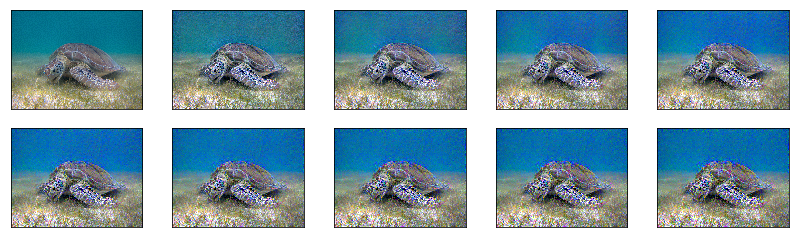

In [0]:
best_img, best_loss = run_style_transfer(content_path, style_path)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

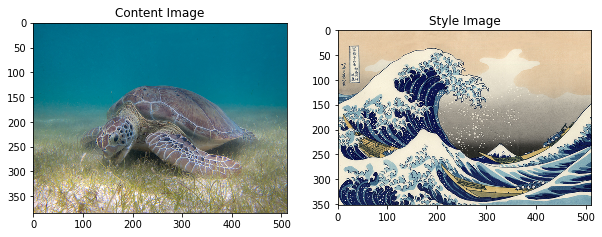

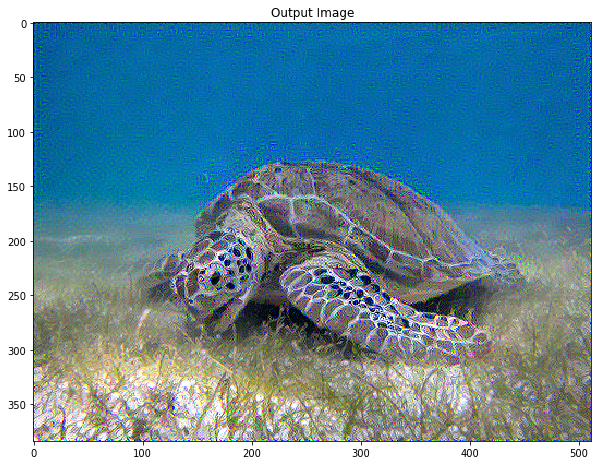

In [0]:
show_results(best_img, content_path, style_path)